<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/CNN_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [2]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 91.3 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 147 kB 87.6 MB/s 
     |████████████████████████████████| 112 kB 87.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a01de941dd4e08b9cb5cd54708669ee9dff84bfed21a036fdb1e18d99b403d56
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [3]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [5]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [6]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [7]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [8]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [9]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [10]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [12]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [13]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [14]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [15]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [16]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

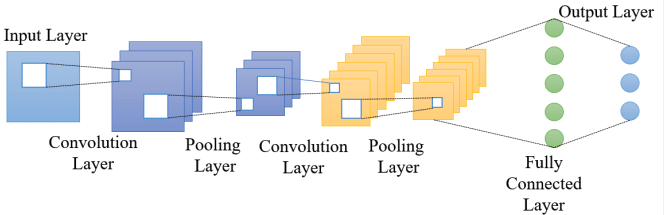

In [17]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size1=9, kernel_size2=9, n_channels1=32, n_channels2=64, pool_size=2,seq_len=72):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)     #the first convolution layer
        self.pool1 = nn.AvgPool1d(pool_size)                                         #average pooling layer
        self.zp1 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  


        self.conv2 = nn.Conv1d(n_channels1, n_channels2, kernel_size=kernel_size2)   #the second convolution layer
        self.pool2 = nn.AvgPool1d(pool_size)                                         #average pooling later 
        self.zp2 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.linear1 = nn.Linear(n_channels2*seq_len//(pool_size*pool_size), output_dim)    #Linear layer


    def forward(self, x):
        x = x.permute(0, 2, 1)
        #print(x.shape)

        y1 = self.zp1(x)
        y1 = torch.relu(self.conv1(y1))
        #print(y1.shape)
        y1 = self.pool1(y1)
        #print(y1.shape)

        y1 = self.zp2(y1)
        y1 = torch.relu(self.conv2(y1))
        #print(y1.shape)
        y1 = self.pool2(y1)
        #print(y1.shape)

        y1 = y1.permute(0, 2, 1) 

        out = torch.flatten(y1, start_dim=1)
        #print(out.shape)
        out = self.linear1(out)
        return out
    

for testing the dimension of the model


In [17]:
#x = torch.rand(64, 120, 9)

#model = CNN(input_dim = 9, 
#            output_dim=24, 
#            kernel_size1=9, 
#            n_channels1=32, 
#            n_channels2=64, 
#            pool_size=2,
#            seq_len=24*5)

#y= model(x)
#y.shape

In [24]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = CNN(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = trial.suggest_int("kernel_L1", 3, 10), 
                kernel_size2 = trial.suggest_int("kernel_L2", 3, 10),
                n_channels1 = trial.suggest_int("hidden_L1", 16, 128), 
                n_channels2 = trial.suggest_int("hidden_L2", 16, 128), 
                pool_size = 2, #trial.suggest_int("pool_size", 2, 5),
                seq_len=24*5).cuda() 

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "CNN_BO.pt")


        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
            # Save a trained model to a file.
        #with open("CNN.pickle".format(trial.number), "wb") as fout:
        #    pickle.dump(model, fout)
    return min_val_loss

In [25]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=50)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #with open("CNN.pickle".format(study.best_trial.number), "rb") as fin:
    #    best_clf = pickle.load(fin)

[I 2022-12-22 23:14:35,289] A new study created in memory with name: no-name-f0a4be25-1f39-4dfa-a5bd-e7e82d09fb10


Iter:  0 train:  269.3974352553487 val:  39.68045227229595
Iter:  20 train:  36.47087590768933 val:  29.247758524492383


[I 2022-12-22 23:15:35,068] Trial 0 finished with value: 26.787022853270173 and parameters: {'kernel_L1': 9, 'kernel_L2': 6, 'hidden_L1': 85, 'hidden_L2': 43, 'lr': 0.0002746908810900577}. Best is trial 0 with value: 26.787022853270173.


Iter:  0 train:  343.2116884961724 val:  48.64497861638665
Iter:  20 train:  45.85704800859094 val:  28.70221146941185


[I 2022-12-22 23:17:02,800] Trial 1 finished with value: 27.981302361935377 and parameters: {'kernel_L1': 5, 'kernel_L2': 10, 'hidden_L1': 103, 'hidden_L2': 117, 'lr': 5.6408659702090284e-05}. Best is trial 0 with value: 26.787022853270173.


Iter:  0 train:  658.6240561008453 val:  62.79912196844816
Iter:  20 train:  69.66145838424563 val:  28.883337151259184
Iter:  40 train:  56.972711618989706 val:  28.39958940818906
Iter:  60 train:  49.066267512738705 val:  29.17921595647931


[I 2022-12-22 23:19:30,449] Trial 2 finished with value: 26.87410559039563 and parameters: {'kernel_L1': 10, 'kernel_L2': 5, 'hidden_L1': 114, 'hidden_L2': 114, 'lr': 1.987022602653496e-05}. Best is trial 0 with value: 26.787022853270173.


Iter:  0 train:  626.2657550722361 val:  60.41337262094021
Iter:  20 train:  69.196387976408 val:  28.421986108645797
Iter:  40 train:  55.5668909996748 val:  26.361281475052238


[I 2022-12-22 23:21:28,569] Trial 3 finished with value: 25.948761170729995 and parameters: {'kernel_L1': 9, 'kernel_L2': 8, 'hidden_L1': 115, 'hidden_L2': 73, 'lr': 2.5941788711713976e-05}. Best is trial 3 with value: 25.948761170729995.


Iter:  0 train:  436.47883762419224 val:  58.38072343543172
Iter:  20 train:  62.72480087727308 val:  26.811010697856545
Iter:  40 train:  49.39083123579621 val:  24.90534968301654
Iter:  60 train:  42.219230614602566 val:  25.51586040109396


[I 2022-12-22 23:23:51,623] Trial 4 finished with value: 24.486789983697236 and parameters: {'kernel_L1': 3, 'kernel_L2': 9, 'hidden_L1': 25, 'hidden_L2': 125, 'lr': 5.189047404563587e-05}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  1747.1587954759598 val:  184.04383665323257


[I 2022-12-22 23:24:05,133] Trial 5 pruned. 


Iter:  0 train:  335.91719640791416 val:  39.548710234463215
Iter:  20 train:  51.24666979908943 val:  25.43005681410432


[I 2022-12-22 23:25:26,231] Trial 6 finished with value: 25.43005681410432 and parameters: {'kernel_L1': 6, 'kernel_L2': 3, 'hidden_L1': 94, 'hidden_L2': 57, 'lr': 0.00012478156382396963}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  325.33917750418186 val:  44.0816059242934
Iter:  20 train:  47.163858231157064 val:  28.16340241394937


[I 2022-12-22 23:26:37,370] Trial 7 finished with value: 25.917225278913975 and parameters: {'kernel_L1': 4, 'kernel_L2': 5, 'hidden_L1': 70, 'hidden_L2': 95, 'lr': 0.00010309830994728962}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  279.7163370549679 val:  39.563740998506546


[I 2022-12-22 23:27:08,246] Trial 8 pruned. 


Iter:  0 train:  306.13627041876316 val:  45.51192074641585
Iter:  20 train:  40.362551264464855 val:  33.04456035606563


[I 2022-12-22 23:28:10,464] Trial 9 finished with value: 26.08456500992179 and parameters: {'kernel_L1': 5, 'kernel_L2': 8, 'hidden_L1': 83, 'hidden_L2': 55, 'lr': 0.00017940591727053987}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  187.89923775941133 val:  34.321436159312725


[I 2022-12-22 23:32:12,384] Trial 10 pruned. 


Iter:  0 train:  600.7885831594467 val:  58.02646145969629


[I 2022-12-22 23:32:25,633] Trial 11 pruned. 


Iter:  0 train:  654.0588375627995 val:  64.63404711708426


[I 2022-12-22 23:32:39,014] Trial 12 pruned. 


Iter:  0 train:  193.78449297696352 val:  33.77202073857188
Iter:  20 train:  21.397971354424953 val:  36.893482990562916


[I 2022-12-22 23:33:31,223] Trial 13 finished with value: 25.587826173752546 and parameters: {'kernel_L1': 3, 'kernel_L2': 9, 'hidden_L1': 54, 'hidden_L2': 96, 'lr': 0.0005926399371550918}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  337.70127464830875 val:  44.62690998055041


[I 2022-12-22 23:33:48,615] Trial 14 pruned. 


Iter:  0 train:  585.2239174991846 val:  64.33309700340033


[I 2022-12-22 23:34:02,679] Trial 15 pruned. 


Iter:  0 train:  294.2930834889412 val:  40.98271404765546


[I 2022-12-22 23:34:21,049] Trial 16 pruned. 


Iter:  0 train:  219.73744567483664 val:  37.09246435947716


[I 2022-12-22 23:34:39,186] Trial 17 pruned. 


Iter:  0 train:  1690.866116464138 val:  182.61788669228554


[I 2022-12-22 23:34:52,538] Trial 18 pruned. 


Iter:  0 train:  1181.7053622603416 val:  87.03517992049456


[I 2022-12-22 23:35:05,592] Trial 19 pruned. 


Iter:  0 train:  349.0558148473501 val:  49.45005512610078


[I 2022-12-22 23:35:20,460] Trial 20 pruned. 


Iter:  0 train:  176.09376291930676 val:  30.85402649641037
Iter:  20 train:  14.6730054654181 val:  45.03713412210345


[I 2022-12-22 23:36:10,625] Trial 21 finished with value: 25.751151273027062 and parameters: {'kernel_L1': 3, 'kernel_L2': 9, 'hidden_L1': 55, 'hidden_L2': 128, 'lr': 0.000940881838801136}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  191.18846394121647 val:  35.42378618940711


[I 2022-12-22 23:36:32,873] Trial 22 pruned. 


Iter:  0 train:  199.82918643951416 val:  32.14588060230017


[I 2022-12-22 23:36:51,291] Trial 23 pruned. 


Iter:  0 train:  344.7655914872885 val:  45.84976430609822


[I 2022-12-22 23:38:37,688] Trial 24 pruned. 


Iter:  0 train:  241.90316778421402 val:  37.097604773938656


[I 2022-12-22 23:38:56,336] Trial 25 pruned. 


Iter:  0 train:  512.2804478704929 val:  55.70764684677124


[I 2022-12-22 23:39:09,876] Trial 26 pruned. 


Iter:  0 train:  221.10758528113365 val:  38.82015836238861


[I 2022-12-22 23:39:35,304] Trial 27 pruned. 


Iter:  0 train:  203.24723100662231 val:  33.30437834188342
Iter:  20 train:  31.819956492632627 val:  38.80618104338646


[I 2022-12-22 23:40:22,695] Trial 28 finished with value: 25.58713912218809 and parameters: {'kernel_L1': 4, 'kernel_L2': 6, 'hidden_L1': 39, 'hidden_L2': 45, 'lr': 0.0007092952653457719}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  308.5491337478161 val:  39.856165297329426


[I 2022-12-22 23:40:35,948] Trial 29 pruned. 


Iter:  0 train:  1264.7274678945541 val:  133.24328407645226


[I 2022-12-22 23:40:49,372] Trial 30 pruned. 


Iter:  0 train:  222.844376437366 val:  33.694919530302286


[I 2022-12-22 23:41:14,192] Trial 31 pruned. 


Iter:  0 train:  254.11252393573523 val:  36.31765602901578
Iter:  20 train:  43.45543439313769 val:  28.50174551270902


[I 2022-12-22 23:42:17,207] Trial 32 finished with value: 25.31054400280118 and parameters: {'kernel_L1': 3, 'kernel_L2': 7, 'hidden_L1': 37, 'hidden_L2': 53, 'lr': 0.0003135591788755698}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  252.47432893514633 val:  38.24302161857486
Iter:  20 train:  44.463480938225985 val:  27.861882818862796


[I 2022-12-22 23:43:20,005] Trial 33 finished with value: 25.072083896026015 and parameters: {'kernel_L1': 4, 'kernel_L2': 6, 'hidden_L1': 38, 'hidden_L2': 52, 'lr': 0.0002860228714937502}. Best is trial 4 with value: 24.486789983697236.


Iter:  0 train:  281.14417457580566 val:  43.16913955286145
Iter:  20 train:  52.86800467222929 val:  23.61728708446026


[I 2022-12-22 23:44:30,580] Trial 34 finished with value: 22.992424484342337 and parameters: {'kernel_L1': 10, 'kernel_L2': 5, 'hidden_L1': 18, 'hidden_L2': 52, 'lr': 0.0003109822265584183}. Best is trial 34 with value: 22.992424484342337.


Iter:  0 train:  291.9873607158661 val:  45.402241479605436


[I 2022-12-22 23:44:43,743] Trial 35 pruned. 


Iter:  0 train:  254.8868412449956 val:  38.37290743365884


[I 2022-12-22 23:46:01,993] Trial 36 pruned. 


Iter:  0 train:  309.5854144394398 val:  39.61876987107098


[I 2022-12-22 23:46:14,995] Trial 37 pruned. 


Iter:  0 train:  369.50793877243996 val:  47.180789202451706


[I 2022-12-22 23:46:28,226] Trial 38 pruned. 


Iter:  0 train:  198.78760895878077 val:  38.39196879416704


[I 2022-12-22 23:46:44,013] Trial 39 pruned. 


Iter:  0 train:  520.345194965601 val:  61.614008482545614


[I 2022-12-22 23:47:51,554] Trial 40 pruned. 


Iter:  0 train:  231.647591650486 val:  45.984869953244925


[I 2022-12-22 23:48:22,043] Trial 41 pruned. 


Iter:  0 train:  282.7791359126568 val:  40.137486442923546


[I 2022-12-22 23:48:42,822] Trial 42 pruned. 


Iter:  0 train:  276.3036152049899 val:  39.2947024255991


[I 2022-12-22 23:48:57,104] Trial 43 pruned. 


Iter:  0 train:  404.99887242913246 val:  49.61468970775604


[I 2022-12-22 23:49:10,664] Trial 44 pruned. 


Iter:  0 train:  730.7540316283703 val:  63.023084715008736


[I 2022-12-22 23:49:23,818] Trial 45 pruned. 


Iter:  0 train:  270.62242866307497 val:  43.07239539921284


[I 2022-12-22 23:49:36,930] Trial 46 pruned. 


Iter:  0 train:  444.3644653111696 val:  54.517504297196865


[I 2022-12-22 23:49:51,345] Trial 47 pruned. 


Iter:  0 train:  415.6452734321356 val:  43.81762816384435


[I 2022-12-22 23:50:04,822] Trial 48 pruned. 


Iter:  0 train:  295.04343566298485 val:  47.364746265113354


[I 2022-12-22 23:50:18,853] Trial 49 pruned. 


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  36
  Number of complete trials:  14
Best trial:
  Value:  22.992424484342337
  Params: 
    kernel_L1: 10
    kernel_L2: 5
    hidden_L1: 18
    hidden_L2: 52
    lr: 0.0003109822265584183


<ipython-input-26-39a959d59534>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", 'hidden_L1', 'hidden_L2', "lr" ])


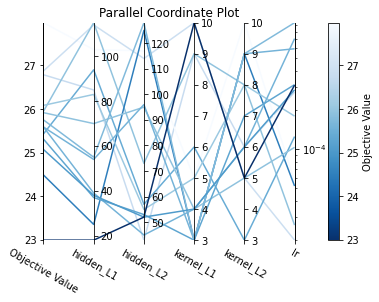

In [26]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", 'hidden_L1', 'hidden_L2', "lr" ])
optuna.visualization.plot_param_importances(study)

In [27]:
#Download the PT file
from google.colab import files
files.download('CNN_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#Read the pk file
model = CNN(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = 10, 
                kernel_size2 = 5,
                n_channels1 = 18, 
                n_channels2 = 52, 
                pool_size = 2, 
                seq_len=24*5).cuda()

model.load_state_dict(torch.load("CNN_BO.pt"))

<All keys matched successfully>

In [19]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [20]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [23]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   122.8777821910816
R^2                :        0.9725737716638109
Mean Absolute Error:        96.81979746825156
MAPE               :        0.016202714449653773


error for next 2 hour prediction
Root Mean Squared Error :   133.89224412437784
R^2                :        0.9665866662583029
Mean Absolute Error:        104.91464457730149
MAPE               :        0.017697754544620733


error for next 3 hour prediction
Root Mean Squared Error :   142.72441875754555
R^2                :        0.9603125373575709
Mean Absolute Error:        110.2836605923847
MAPE               :        0.018471614792812917


error for next 24 hour prediction
Root Mean Squared Error :   240.5728794504636
R^2                :        0.8808292543874733
Mean Absolute Error:        190.8650535551751
MAPE               :        0.032628425151514956


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


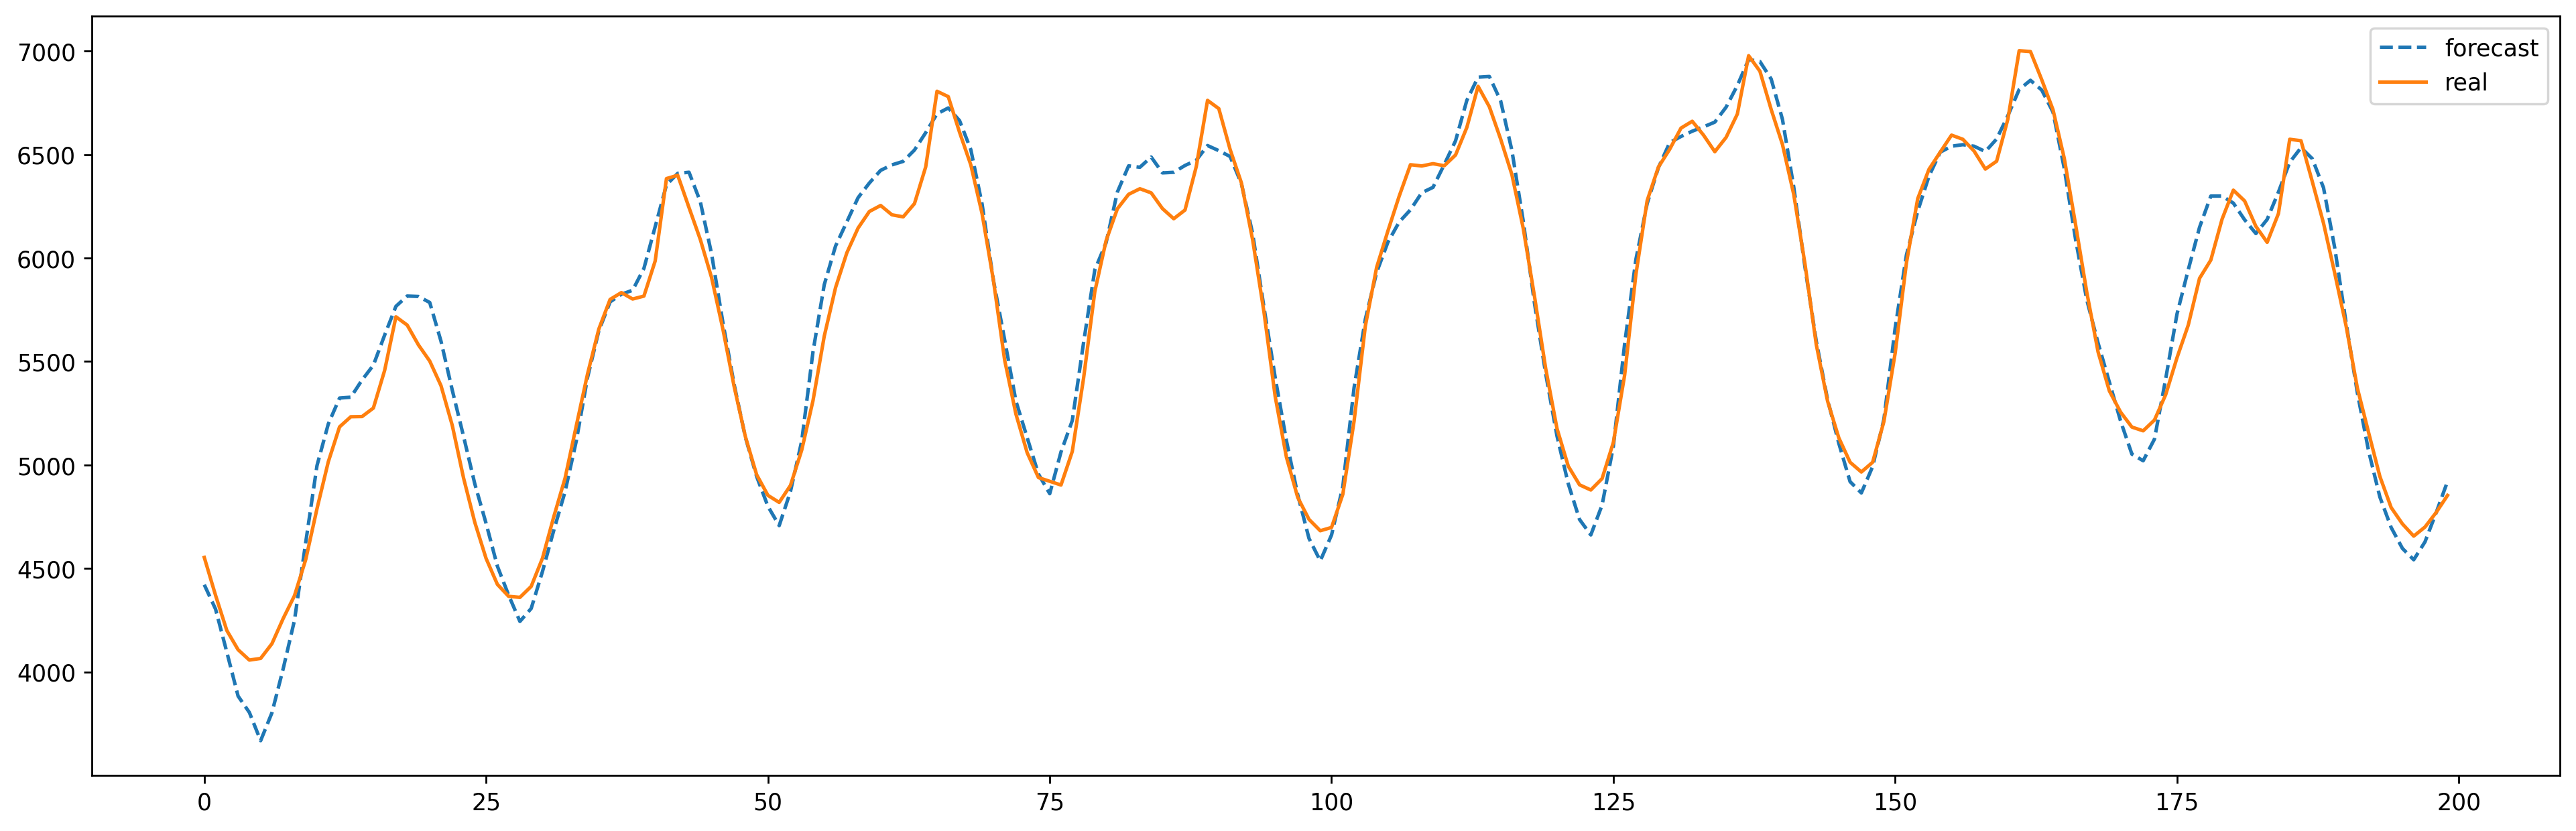

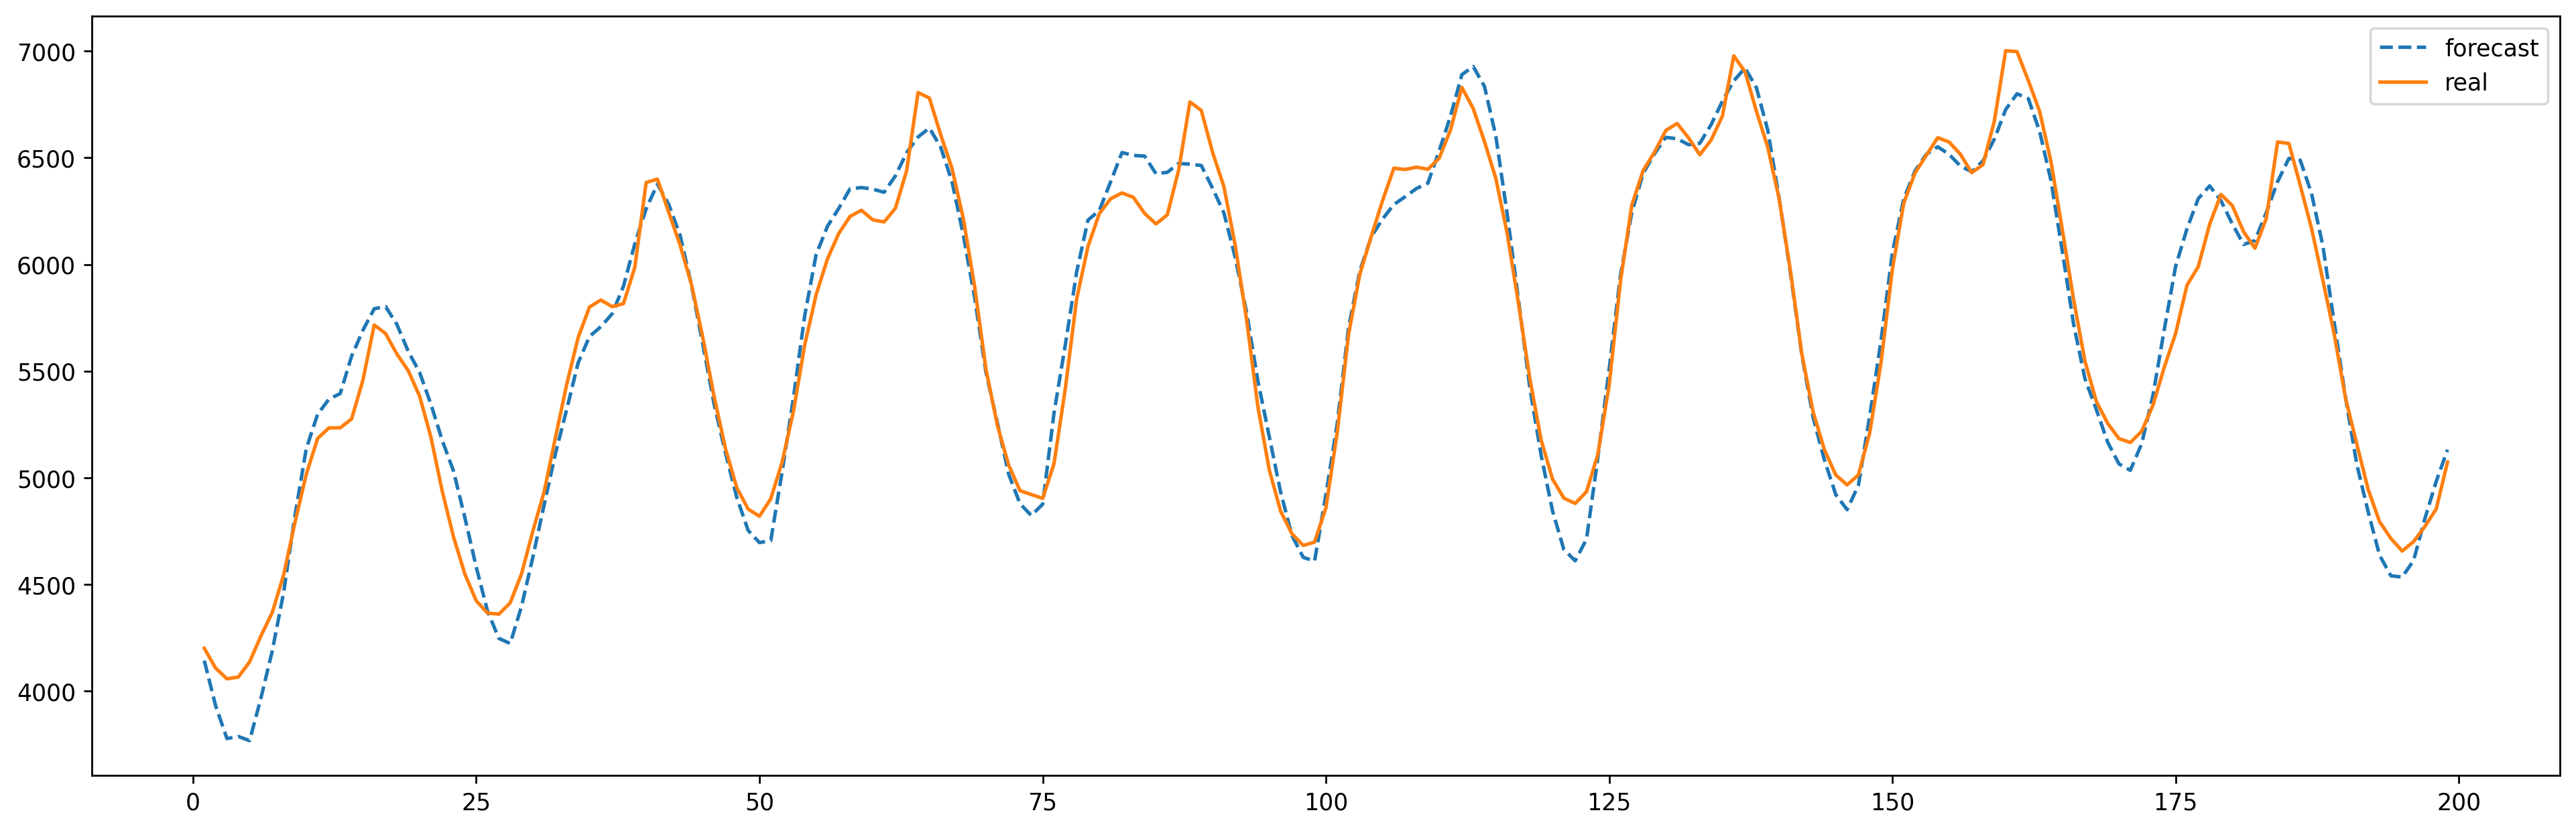

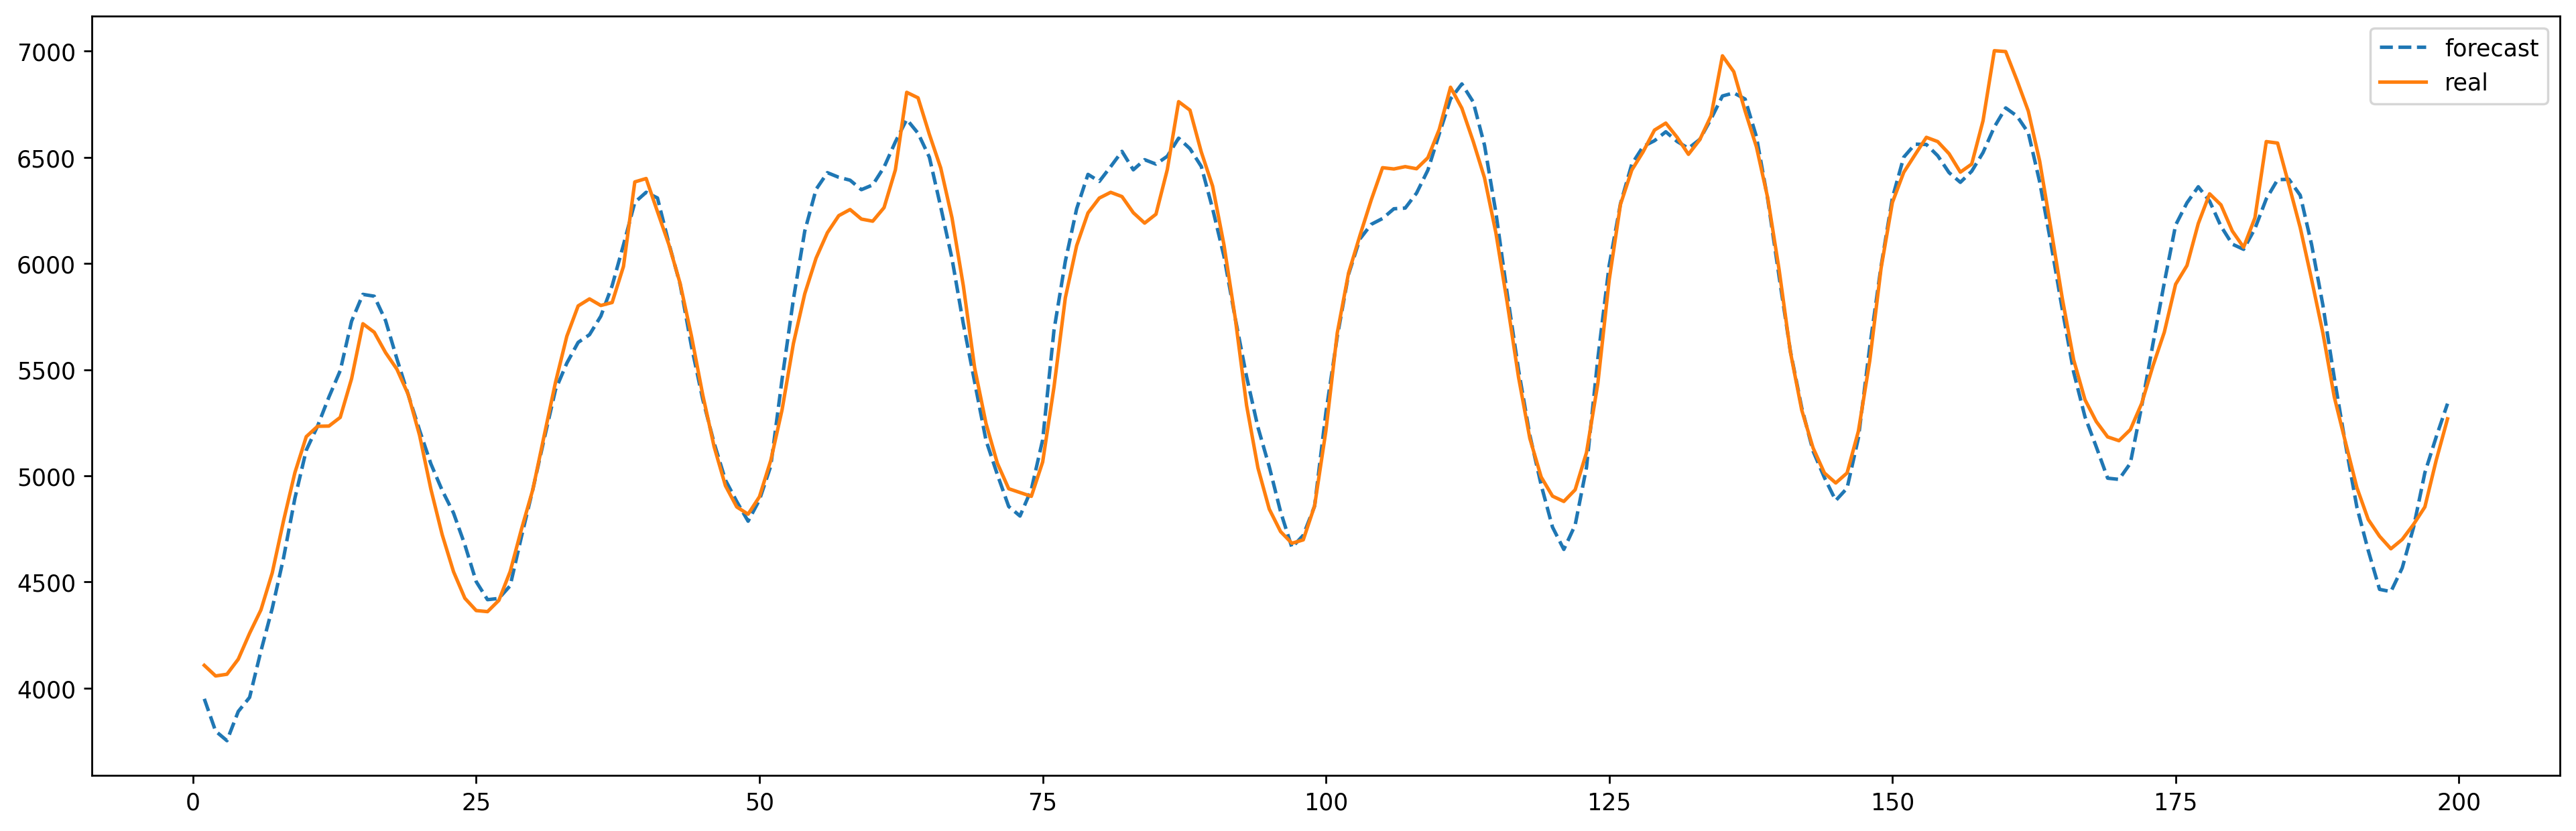

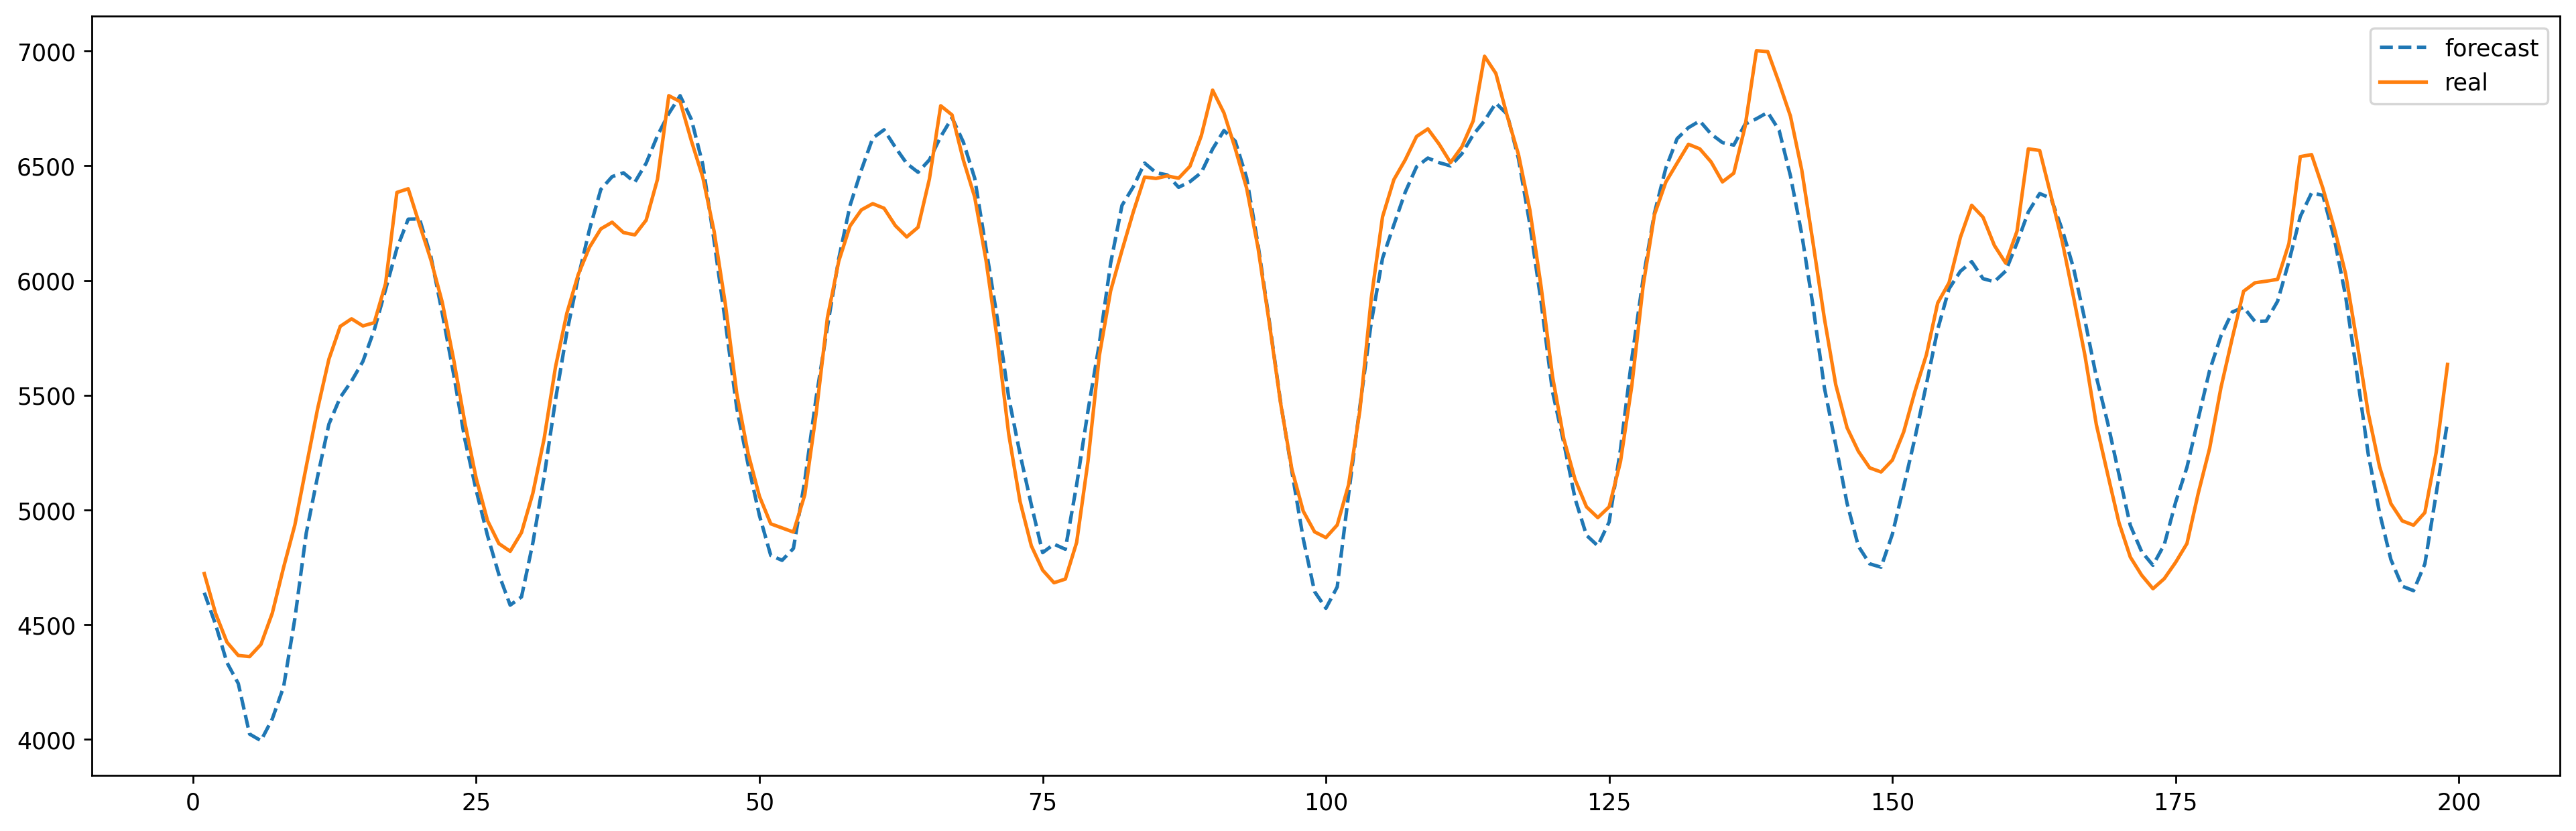

In [30]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the series (the next 24-hour forecast for a specific day)

In [25]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

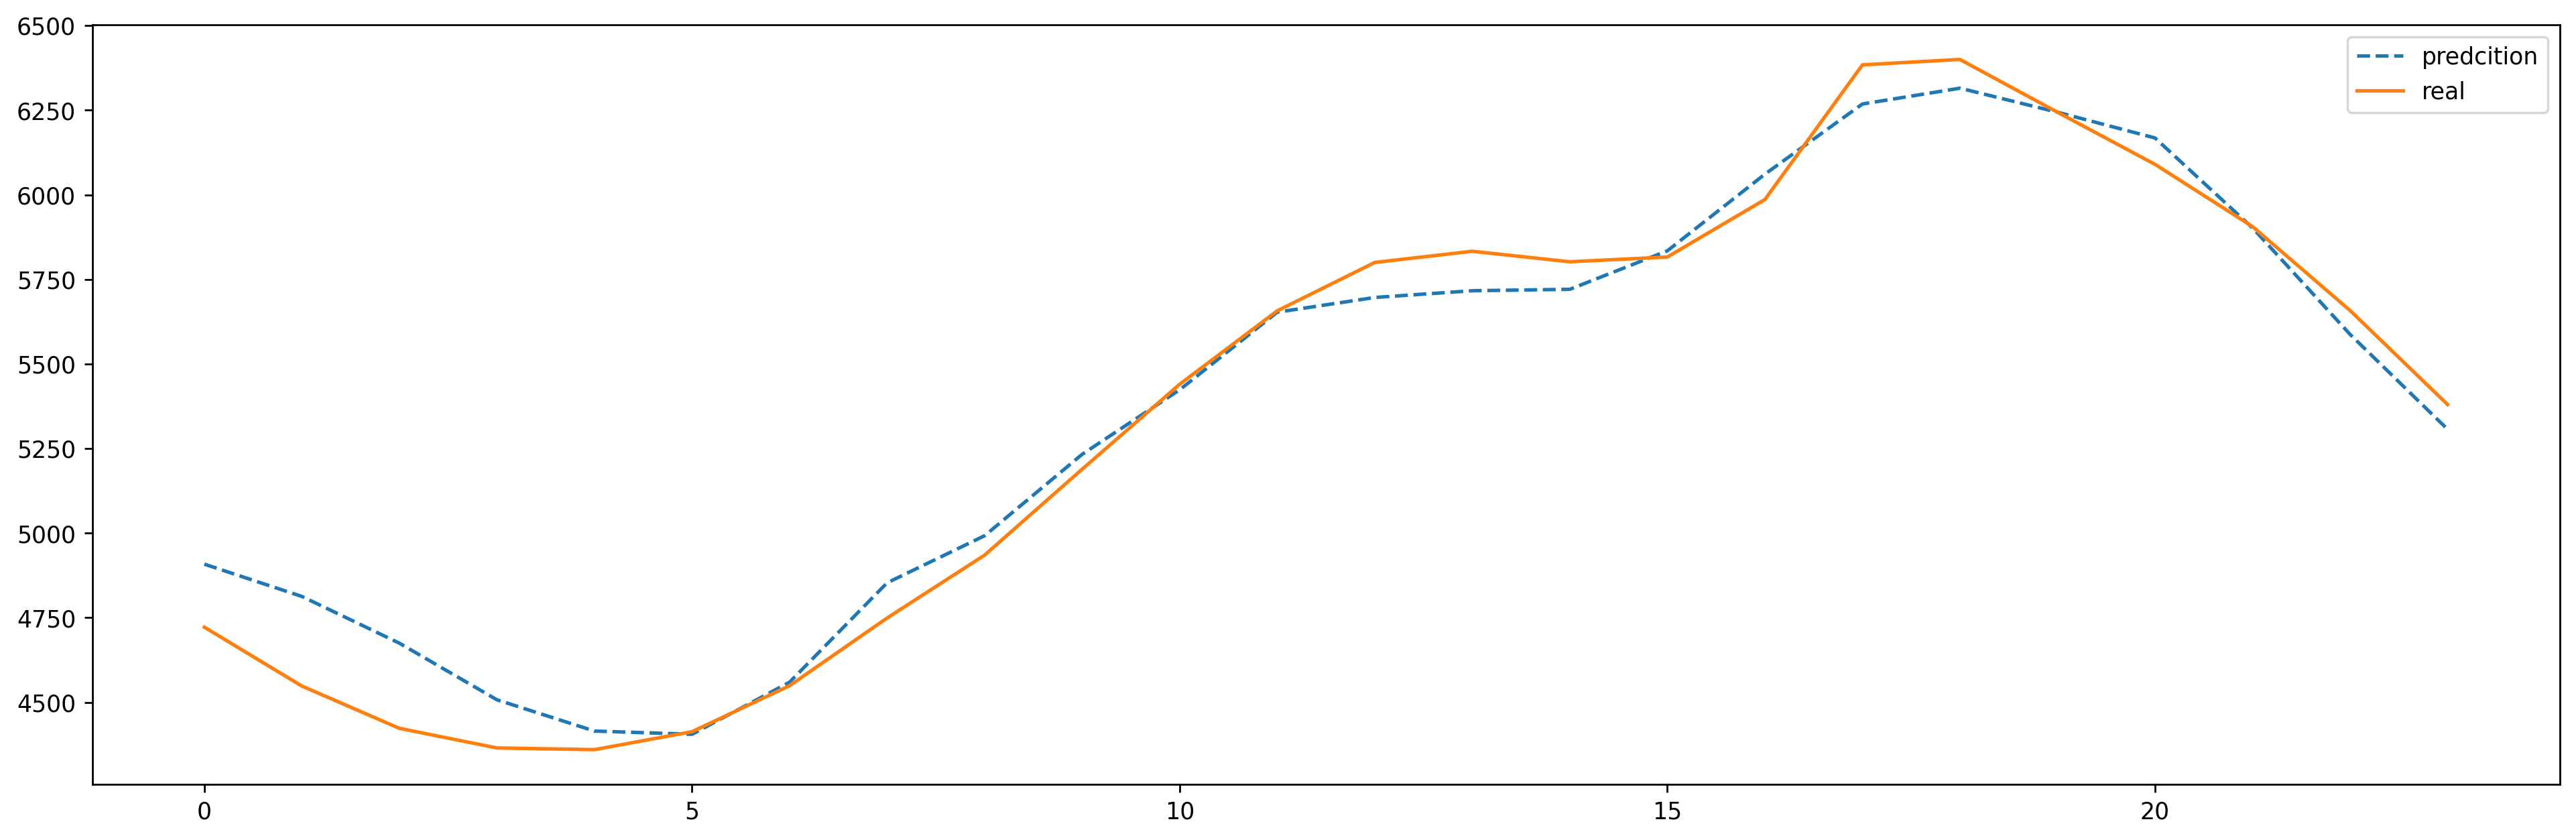

In [28]:
figure(figsize=(19, 6), dpi=250)

#select the day to forecast
day=1

dates = range(len(prediction_descaled))
plt.plot(dates[0:24], prediction_descaled[day*24] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[day*24], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();